In [1]:
##########################################################    Bert    ##########################################################

In [2]:
# חלק 1: ייבוא ספריות
import sys
import random
from collections import Counter

import pandas as pd
import numpy as np

import torch
import accelerate
import huggingface_hub

from pathlib import Path
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# חלק 2: בדיקת גרסאות וסביבת הפיתוח
print("Python version:", sys.version.split()[0])
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
print("accelerate:", accelerate.__version__)
print("hf_hub:", huggingface_hub.__version__)

Python version: 3.11.11
PyTorch version: 2.5.1
CUDA version: 11.8
Device name: NVIDIA GeForce RTX 3060 Ti
accelerate: 1.7.0
hf_hub: 0.31.2


In [4]:
# חלק 3: הגדרת מכשיר (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    raise EnvironmentError("CUDA device not available; aborting to avoid CPU run.")
print(f"Using device: {device} ({torch.cuda.get_device_name(0)})")

Using device: cuda (NVIDIA GeForce RTX 3060 Ti)


In [5]:
# חלק 4: פונקציות עזר
def print_stats(texts, labels, label_cols, name):
    """
    מדפיס:
      • כמה קומבינציות ייחודיות מתוך 27 קיימות
      • עבור כל לייבל: כמה דוגמאות עם הערכים 0,1,2,3
    """
    combos = [tuple(l) for l in labels]
    unique_combos = set(combos)
    print(f"\n=== {name} ===")
    print(f"Unique label combinations: {len(unique_combos)} / 27")
    for i, lab in enumerate(label_cols):
        vals = [l[i] for l in labels]
        counts = Counter(vals)
        print(f"Label '{lab}': " + ", ".join(f"{v}: {counts.get(v,0)}" for v in [0,1,2,3]))


def load_data(path, encoding='utf-8'):
    """
    טוען CSV ומחזיר:
      • texts: רשימת מיתרי הטקסט
      • labels: רשימת רשימות של ארבעת הלייבלים
      • df: ה-DataFrame המלא
    """
    try:
        df = pd.read_csv(path, encoding=encoding)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1')
    cols = df.columns.tolist()
    if len(cols) < 5:
        raise ValueError(f"Expected >=5 columns but found {len(cols)}")
    text_col = cols[0]
    label_cols = cols[-4:]
    print(f"Using text column: '{text_col}', label columns: {label_cols}")
    df.dropna(subset=[text_col], inplace=True)
    texts = df[text_col].astype(str).tolist()
    labels = df[label_cols].astype(int).values.tolist()
    return texts, labels, df


def split_with_coverage(X, y, test_size, initial_rs):
    """
    מחלק את X ו־y ל־train/val באופן אקראי (עם שינוי seed עד
    שמתקבל כיסוי מלא של הערכים 0–3 בכל לייבל בשני הסטים).
    """
    rs = initial_rs
    while True:
        X_tr, X_v, y_tr, y_v = train_test_split(
            X, y, test_size=test_size, random_state=rs, shuffle=True
        )
        ok = True
        for i in range(y.shape[1]):
            if set(y_tr[:,i]) != {0,1,2,3} or set(y_v[:,i]) != {0,1,2,3}:
                ok = False
                break
        if ok:
            return X_tr, X_v, y_tr, y_v
        rs += 1

In [6]:
# חלק 5: הגדרת Tokenizer ו־Dataset
tokenizer = None
def set_tokenizer(tok):
    global tokenizer
    tokenizer = tok

class CourseDataset(Dataset):
    def __init__(self, texts, labels, max_length=128):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [7]:
# חלק 6: הגדרת המודל (BERT עם 4 ראשים)
class CourseSentimentModel(nn.Module):
    def __init__(self, model_name, num_labels_per_task):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden = self.bert.config.hidden_size
        self.classifiers = nn.ModuleList([
            nn.Linear(hidden, num_labels_per_task) for _ in range(4)
        ])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]
        return [clf(cls) for clf in self.classifiers]

In [8]:
# חלק 7: פונקציות אימון והערכה
def train_epoch(model, loader, optimizer, scheduler, loss_fn):
    model.train()
    for batch in loader:
        ids  = batch['input_ids'].to(device, non_blocking=True)
        mask = batch['attention_mask'].to(device, non_blocking=True)
        labs = batch['labels'].to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss = sum(loss_fn(logit, labs[:, i]) for i, logit in enumerate(logits))
        loss.backward()
        optimizer.step()
        scheduler.step()

def eval_model(model, loader):
    model.eval()
    correct_per_label = [0]*4
    correct_exact = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            ids   = batch['input_ids'].to(device)
            mask  = batch['attention_mask'].to(device)
            labs  = batch['labels'].to(device)
            preds = torch.stack([torch.argmax(l,dim=1) for l in model(ids,mask)], dim=1)
            matches = (preds == labs)
            for i in range(4):
                correct_per_label[i] += matches[:,i].sum().item()
            correct_exact += matches.all(dim=1).sum().item()
            total += labs.size(0)
    return [c/total for c in correct_per_label], correct_exact/total

In [9]:
# חלק 8: חיפוש היפר-פרמטרים
def hyperparameter_search(train_ds, val_ds, model_name, hyperparams, num_labels_per_task):
    best = {'exact_match': 0.0}
    best_model = None
    runs = 0
    pin_mem = True
    num_workers = 0
    total_runs = (
        len(hyperparams['learning_rates']) *
        len(hyperparams['batch_sizes']) *
        len(hyperparams['weight_decays']) *
        len(hyperparams['epochs'])
    )
    for lr in hyperparams['learning_rates']:
        for bs in hyperparams['batch_sizes']:
            for wd in hyperparams['weight_decays']:
                for epochs in hyperparams['epochs']:
                    runs += 1
                    print(f"\nRun {runs}/{total_runs}: lr={lr}, bs={bs}, wd={wd}, epochs={epochs}")
                    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,
                                              pin_memory=pin_mem, num_workers=num_workers)
                    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False,
                                             pin_memory=pin_mem, num_workers=num_workers)
                    model = CourseSentimentModel(model_name, num_labels_per_task).to(device)
                    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
                    steps = epochs * len(train_loader)
                    scheduler = get_linear_schedule_with_warmup(optimizer, 0, steps)
                    loss_fn = nn.CrossEntropyLoss()

                    for epoch in range(1, epochs+1):
                        desc = f"Run {runs}/{total_runs} · Epoch {epoch}/{epochs}"
                        pbar = tqdm(train_loader, total=len(train_loader),
                                    desc=desc, unit="batch", dynamic_ncols=True)
                        for batch in pbar:
                            ids  = batch['input_ids'].to(device, non_blocking=True)
                            mask = batch['attention_mask'].to(device, non_blocking=True)
                            labs = batch['labels'].to(device, non_blocking=True)
                            optimizer.zero_grad()
                            logits = model(ids, mask)
                            loss = sum(loss_fn(logit, labs[:, i]) for i, logit in enumerate(logits))
                            loss.backward()
                            optimizer.step()
                            scheduler.step()
                            pbar.set_postfix(loss=f"{loss.item():.4f}")
                        _, acc_ex = eval_model(model, val_loader)
                        pbar.write(f"Exact-Match after Epoch {epoch}: {acc_ex:.4f}")
                        pbar.close()

                    if acc_ex > best['exact_match']:
                        best.update({
                            'exact_match': acc_ex,
                            'params': {
                                'learning_rate': lr,
                                'batch_size':    bs,
                                'weight_decay':  wd,
                                'epochs':        epochs
                            }
                        })
                        best_model = model

    return best, runs, best_model

In [10]:
# חלק 9: הזרימה הראשית (main)
def main():
    global BEST_BATCH_SIZE

    # הגדרות seed לייציבות
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # 9.1: טעינת הנתונים
    DATA_PATH = r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv"
    texts, labels_list, df = load_data(DATA_PATH)
    N = len(texts)
    print(f"Total examples in dataset: {N}")

    # 9.2: אימות עמודות הלייבלים
    labels_cols = ['difficulty', 'interest', 'usefulness', 'teaching_quality']
    assert all(col in df.columns for col in labels_cols)

    labels_all = df[labels_cols].astype(int).values  # (N,4)

    # 9.3: בניית Evaluation/Test set
    RND = 42
    rng = np.random.RandomState(RND)
    test_idx = set()
    for i, col in enumerate(labels_cols):
        for v in [0,1,2,3]:
            idxs = np.where(labels_all[:,i]==v)[0]
            if len(idxs)==0: continue
            test_idx.add(int(rng.choice(idxs)))
    desired_test = int(round(0.20 * N))
    rem = desired_test - len(test_idx)
    if rem > 0:
        avail = np.array(list(set(range(N)) - test_idx))
        choices = rng.choice(avail, size=rem, replace=False)
        test_idx.update(map(int, choices))
    elif rem < 0:
        to_rem = rng.choice(list(test_idx), size=len(test_idx) - desired_test, replace=False)
        for x in to_rem: test_idx.remove(x)

    test_idx_list = sorted(test_idx)
    X_test = [texts[i] for i in test_idx_list]
    y_test = labels_all[test_idx_list]
    print_stats(X_test, y_test, labels_cols, "Evaluation Set")

    # 9.4: בניית Train+Validation
    train_val_idx = [i for i in range(N) if i not in test_idx]
    X_train_val = [texts[i] for i in train_val_idx]
    y_train_val = labels_all[train_val_idx]

    # 9.5: חלוקה ל־Train/Validation עם כיסוי
    X_train, X_val, y_train, y_val = split_with_coverage(
        X_train_val, np.array(y_train_val), test_size=0.10, initial_rs=RND
    )
    print_stats(X_train, y_train, labels_cols, "Train Set")
    print_stats(X_val,   y_val,   labels_cols, "Validation Set")

    # 9.6: איתחול Tokenizer ויצירת Datasets
    set_tokenizer(AutoTokenizer.from_pretrained("bert-base-multilingual-cased"))
    train_ds = CourseDataset(X_train, y_train.tolist())
    val_ds   = CourseDataset(X_val,   y_val.tolist())

    # 9.7: חיפוש היפר-פרמטרים
    hyperparams = {
        'learning_rates': [5e-5, 3e-5, 2e-5],
        'batch_sizes':    [16, 32],
        'weight_decays':  [0.0, 0.01],
        'epochs': list(range(1, 4)) 
    }
    best, runs, best_model = hyperparameter_search(
        train_ds, val_ds, "bert-base-multilingual-cased",
        hyperparams, num_labels_per_task=4
    )

    BEST_BATCH_SIZE = best['params']['batch_size']
    print(f"\n>>> Best batch size: {BEST_BATCH_SIZE}")
    print(f"Total runs: {runs}")
    print(f"Validation Exact-Match: {best['exact_match']:.4f}")
    print("Best hyperparams:", best['params'])

    # 9.8: שמירת המודל הטוב ביותר
    save_path = Path(r"C:\Users\Gleb\Desktop\N.L.P\best_model.pth")
    torch.save(best_model.state_dict(), save_path)
    print(f"Saved best model to {save_path}")

    # 9.9: הערכה סופית על Test set
    test_ds = CourseDataset(X_test, y_test.tolist())
    test_loader = DataLoader(test_ds, batch_size=BEST_BATCH_SIZE,
                             shuffle=False, pin_memory=True, num_workers=0)

    with torch.no_grad():
        acc_per_label_test, exact_test = eval_model(best_model, test_loader)

    print("\n===== Test-Set Evaluation Results =====")
    print(f"Exact-Match Accuracy on Test set: {exact_test:.4f}")
    for i, lab in enumerate(labels_cols, start=1):
        print(f"Label {i} ({lab}) Accuracy on Test set: {acc_per_label_test[i-1]:.4f}")

In [11]:
# חלק 10: הרצה
if __name__ == "__main__":
    main()

Using text column: 'review', label columns: ['difficulty', 'interest', 'usefulness', 'teaching_quality']
Total examples in dataset: 3500

=== Evaluation Set ===
Unique label combinations: 25 / 27
Label 'difficulty': 0: 426, 1: 63, 2: 63, 3: 148
Label 'interest': 0: 299, 1: 110, 2: 62, 3: 229
Label 'usefulness': 0: 392, 1: 156, 2: 69, 3: 83
Label 'teaching_quality': 0: 410, 1: 120, 2: 66, 3: 104

=== Train Set ===
Unique label combinations: 25 / 27
Label 'difficulty': 0: 1514, 1: 256, 2: 262, 3: 488
Label 'interest': 0: 1013, 1: 340, 2: 259, 3: 908
Label 'usefulness': 0: 1507, 1: 485, 2: 256, 3: 272
Label 'teaching_quality': 0: 1495, 1: 423, 2: 255, 3: 347

=== Validation Set ===
Unique label combinations: 26 / 27
Label 'difficulty': 0: 169, 1: 29, 2: 25, 3: 57
Label 'interest': 0: 122, 1: 31, 2: 21, 3: 106
Label 'usefulness': 0: 161, 1: 53, 2: 21, 3: 45
Label 'teaching_quality': 0: 148, 1: 57, 2: 26, 3: 49


C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Run 1/36: lr=5e-05, bs=16, wd=0.0, epochs=1


Run 1/36 · Epoch 1/1: 100%|██████████| 158/158 [00:29<00:00,  5.40batch/s, loss=1.4434]


Exact-Match after Epoch 1: 0.8821

Run 2/36: lr=5e-05, bs=16, wd=0.0, epochs=2


C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Run 2/36 · Epoch 1/2: 100%|██████████| 158/158 [00:28<00:00,  5.62batch/s, loss=0.4517]


Exact-Match after Epoch 1: 0.8857


Run 2/36 · Epoch 2/2: 100%|██████████| 158/158 [00:28<00:00,  5.61batch/s, loss=0.1034]


Exact-Match after Epoch 2: 0.9071

Run 3/36: lr=5e-05, bs=16, wd=0.0, epochs=3


Run 3/36 · Epoch 1/3: 100%|██████████| 158/158 [00:28<00:00,  5.55batch/s, loss=0.2610]


Exact-Match after Epoch 1: 0.8571


Run 3/36 · Epoch 2/3: 100%|██████████| 158/158 [00:28<00:00,  5.54batch/s, loss=0.3102]


Exact-Match after Epoch 2: 0.9036


Run 3/36 · Epoch 3/3: 100%|██████████| 158/158 [00:29<00:00,  5.41batch/s, loss=0.0574]


Exact-Match after Epoch 3: 0.9321

Run 4/36: lr=5e-05, bs=16, wd=0.01, epochs=1


Run 4/36 · Epoch 1/1: 100%|██████████| 158/158 [00:29<00:00,  5.40batch/s, loss=0.5259]


Exact-Match after Epoch 1: 0.9036

Run 5/36: lr=5e-05, bs=16, wd=0.01, epochs=2


Run 5/36 · Epoch 1/2: 100%|██████████| 158/158 [00:31<00:00,  5.06batch/s, loss=0.1949]


Exact-Match after Epoch 1: 0.8679


Run 5/36 · Epoch 2/2: 100%|██████████| 158/158 [00:28<00:00,  5.46batch/s, loss=0.0825]


Exact-Match after Epoch 2: 0.9036

Run 6/36: lr=5e-05, bs=16, wd=0.01, epochs=3


Run 6/36 · Epoch 1/3: 100%|██████████| 158/158 [00:29<00:00,  5.43batch/s, loss=0.2895]


Exact-Match after Epoch 1: 0.8750


Run 6/36 · Epoch 2/3: 100%|██████████| 158/158 [00:29<00:00,  5.42batch/s, loss=0.1357]


Exact-Match after Epoch 2: 0.9250


Run 6/36 · Epoch 3/3: 100%|██████████| 158/158 [00:30<00:00,  5.26batch/s, loss=0.0525]


Exact-Match after Epoch 3: 0.9393

Run 7/36: lr=5e-05, bs=32, wd=0.0, epochs=1


Run 7/36 · Epoch 1/1: 100%|██████████| 79/79 [00:37<00:00,  2.11batch/s, loss=1.0770]


Exact-Match after Epoch 1: 0.8643

Run 8/36: lr=5e-05, bs=32, wd=0.0, epochs=2


Run 8/36 · Epoch 1/2: 100%|██████████| 79/79 [00:39<00:00,  2.01batch/s, loss=0.6277]


Exact-Match after Epoch 1: 0.8679


Run 8/36 · Epoch 2/2: 100%|██████████| 79/79 [00:36<00:00,  2.15batch/s, loss=0.1903]


Exact-Match after Epoch 2: 0.9179

Run 9/36: lr=5e-05, bs=32, wd=0.0, epochs=3


Run 9/36 · Epoch 1/3: 100%|██████████| 79/79 [00:24<00:00,  3.23batch/s, loss=0.6267]


Exact-Match after Epoch 1: 0.9000


Run 9/36 · Epoch 2/3: 100%|██████████| 79/79 [00:24<00:00,  3.23batch/s, loss=0.0976]


Exact-Match after Epoch 2: 0.9214


Run 9/36 · Epoch 3/3: 100%|██████████| 79/79 [00:27<00:00,  2.87batch/s, loss=0.0973]


Exact-Match after Epoch 3: 0.9321

Run 10/36: lr=5e-05, bs=32, wd=0.01, epochs=1


Run 10/36 · Epoch 1/1: 100%|██████████| 79/79 [00:27<00:00,  2.92batch/s, loss=0.7240]


Exact-Match after Epoch 1: 0.8214

Run 11/36: lr=5e-05, bs=32, wd=0.01, epochs=2


Run 11/36 · Epoch 1/2: 100%|██████████| 79/79 [00:26<00:00,  3.03batch/s, loss=0.7167]


Exact-Match after Epoch 1: 0.8393


Run 11/36 · Epoch 2/2: 100%|██████████| 79/79 [00:29<00:00,  2.68batch/s, loss=0.2595]


Exact-Match after Epoch 2: 0.8964

Run 12/36: lr=5e-05, bs=32, wd=0.01, epochs=3


Run 12/36 · Epoch 1/3: 100%|██████████| 79/79 [00:25<00:00,  3.05batch/s, loss=0.9617]


Exact-Match after Epoch 1: 0.8964


Run 12/36 · Epoch 2/3: 100%|██████████| 79/79 [00:25<00:00,  3.14batch/s, loss=0.2793]


Exact-Match after Epoch 2: 0.9000


Run 12/36 · Epoch 3/3: 100%|██████████| 79/79 [00:24<00:00,  3.18batch/s, loss=0.1505]


Exact-Match after Epoch 3: 0.9286

Run 13/36: lr=3e-05, bs=16, wd=0.0, epochs=1


Run 13/36 · Epoch 1/1: 100%|██████████| 158/158 [00:28<00:00,  5.56batch/s, loss=0.4833]


Exact-Match after Epoch 1: 0.8286

Run 14/36: lr=3e-05, bs=16, wd=0.0, epochs=2


Run 14/36 · Epoch 1/2: 100%|██████████| 158/158 [00:33<00:00,  4.74batch/s, loss=0.3922]


Exact-Match after Epoch 1: 0.8857


Run 14/36 · Epoch 2/2: 100%|██████████| 158/158 [00:28<00:00,  5.52batch/s, loss=0.3820]


Exact-Match after Epoch 2: 0.9036

Run 15/36: lr=3e-05, bs=16, wd=0.0, epochs=3


Run 15/36 · Epoch 1/3: 100%|██████████| 158/158 [00:31<00:00,  4.97batch/s, loss=0.1803]


Exact-Match after Epoch 1: 0.8964


Run 15/36 · Epoch 2/3: 100%|██████████| 158/158 [00:29<00:00,  5.36batch/s, loss=0.4430]


Exact-Match after Epoch 2: 0.9071


Run 15/36 · Epoch 3/3: 100%|██████████| 158/158 [00:30<00:00,  5.25batch/s, loss=0.1091]


Exact-Match after Epoch 3: 0.9250

Run 16/36: lr=3e-05, bs=16, wd=0.01, epochs=1


Run 16/36 · Epoch 1/1: 100%|██████████| 158/158 [00:30<00:00,  5.26batch/s, loss=0.5843]


Exact-Match after Epoch 1: 0.8464

Run 17/36: lr=3e-05, bs=16, wd=0.01, epochs=2


Run 17/36 · Epoch 1/2: 100%|██████████| 158/158 [00:29<00:00,  5.28batch/s, loss=0.5473]


Exact-Match after Epoch 1: 0.8857


Run 17/36 · Epoch 2/2: 100%|██████████| 158/158 [00:31<00:00,  5.04batch/s, loss=0.1081]


Exact-Match after Epoch 2: 0.8893

Run 18/36: lr=3e-05, bs=16, wd=0.01, epochs=3


Run 18/36 · Epoch 1/3: 100%|██████████| 158/158 [00:29<00:00,  5.43batch/s, loss=0.7264]


Exact-Match after Epoch 1: 0.8679


Run 18/36 · Epoch 2/3: 100%|██████████| 158/158 [00:31<00:00,  5.03batch/s, loss=0.2143]


Exact-Match after Epoch 2: 0.9214


Run 18/36 · Epoch 3/3: 100%|██████████| 158/158 [00:30<00:00,  5.16batch/s, loss=0.1049]


Exact-Match after Epoch 3: 0.9393

Run 19/36: lr=3e-05, bs=32, wd=0.0, epochs=1


Run 19/36 · Epoch 1/1: 100%|██████████| 79/79 [00:25<00:00,  3.06batch/s, loss=1.3041]


Exact-Match after Epoch 1: 0.7286

Run 20/36: lr=3e-05, bs=32, wd=0.0, epochs=2


Run 20/36 · Epoch 1/2: 100%|██████████| 79/79 [00:26<00:00,  2.93batch/s, loss=0.5033]


Exact-Match after Epoch 1: 0.8536


Run 20/36 · Epoch 2/2: 100%|██████████| 79/79 [00:24<00:00,  3.16batch/s, loss=0.4752]


Exact-Match after Epoch 2: 0.8929

Run 21/36: lr=3e-05, bs=32, wd=0.0, epochs=3


Run 21/36 · Epoch 1/3: 100%|██████████| 79/79 [00:26<00:00,  3.01batch/s, loss=0.9131]


Exact-Match after Epoch 1: 0.8500


Run 21/36 · Epoch 2/3: 100%|██████████| 79/79 [00:26<00:00,  2.98batch/s, loss=0.4845]


Exact-Match after Epoch 2: 0.9000


Run 21/36 · Epoch 3/3: 100%|██████████| 79/79 [00:26<00:00,  3.00batch/s, loss=0.2260]


Exact-Match after Epoch 3: 0.9143

Run 22/36: lr=3e-05, bs=32, wd=0.01, epochs=1


Run 22/36 · Epoch 1/1: 100%|██████████| 79/79 [00:25<00:00,  3.06batch/s, loss=1.1940]


Exact-Match after Epoch 1: 0.7429

Run 23/36: lr=3e-05, bs=32, wd=0.01, epochs=2


Run 23/36 · Epoch 1/2: 100%|██████████| 79/79 [00:25<00:00,  3.08batch/s, loss=1.0384]


Exact-Match after Epoch 1: 0.8357


Run 23/36 · Epoch 2/2: 100%|██████████| 79/79 [00:24<00:00,  3.19batch/s, loss=0.4338]


Exact-Match after Epoch 2: 0.8893

Run 24/36: lr=3e-05, bs=32, wd=0.01, epochs=3


Run 24/36 · Epoch 1/3: 100%|██████████| 79/79 [00:25<00:00,  3.14batch/s, loss=0.6921]


Exact-Match after Epoch 1: 0.8643


Run 24/36 · Epoch 2/3: 100%|██████████| 79/79 [00:27<00:00,  2.92batch/s, loss=0.2640]


Exact-Match after Epoch 2: 0.9143


Run 24/36 · Epoch 3/3: 100%|██████████| 79/79 [00:26<00:00,  2.96batch/s, loss=0.1484]


Exact-Match after Epoch 3: 0.9250

Run 25/36: lr=2e-05, bs=16, wd=0.0, epochs=1


Run 25/36 · Epoch 1/1: 100%|██████████| 158/158 [00:30<00:00,  5.25batch/s, loss=0.8469]


Exact-Match after Epoch 1: 0.8250

Run 26/36: lr=2e-05, bs=16, wd=0.0, epochs=2


Run 26/36 · Epoch 1/2: 100%|██████████| 158/158 [00:29<00:00,  5.28batch/s, loss=0.6344]


Exact-Match after Epoch 1: 0.8321


Run 26/36 · Epoch 2/2: 100%|██████████| 158/158 [00:30<00:00,  5.23batch/s, loss=0.3343]


Exact-Match after Epoch 2: 0.9000

Run 27/36: lr=2e-05, bs=16, wd=0.0, epochs=3


Run 27/36 · Epoch 1/3: 100%|██████████| 158/158 [00:32<00:00,  4.86batch/s, loss=0.5490]


Exact-Match after Epoch 1: 0.8500


Run 27/36 · Epoch 2/3: 100%|██████████| 158/158 [00:30<00:00,  5.27batch/s, loss=0.6089]


Exact-Match after Epoch 2: 0.9000


Run 27/36 · Epoch 3/3: 100%|██████████| 158/158 [00:30<00:00,  5.26batch/s, loss=0.0980]


Exact-Match after Epoch 3: 0.8964

Run 28/36: lr=2e-05, bs=16, wd=0.01, epochs=1


Run 28/36 · Epoch 1/1: 100%|██████████| 158/158 [00:31<00:00,  4.98batch/s, loss=1.0611]


Exact-Match after Epoch 1: 0.7821

Run 29/36: lr=2e-05, bs=16, wd=0.01, epochs=2


Run 29/36 · Epoch 1/2: 100%|██████████| 158/158 [00:29<00:00,  5.37batch/s, loss=1.2047]


Exact-Match after Epoch 1: 0.8393


Run 29/36 · Epoch 2/2: 100%|██████████| 158/158 [00:30<00:00,  5.20batch/s, loss=0.1679]


Exact-Match after Epoch 2: 0.8929

Run 30/36: lr=2e-05, bs=16, wd=0.01, epochs=3


Run 30/36 · Epoch 1/3: 100%|██████████| 158/158 [00:30<00:00,  5.21batch/s, loss=0.3710]


Exact-Match after Epoch 1: 0.8429


Run 30/36 · Epoch 2/3: 100%|██████████| 158/158 [00:29<00:00,  5.29batch/s, loss=0.5065]


Exact-Match after Epoch 2: 0.8893


Run 30/36 · Epoch 3/3: 100%|██████████| 158/158 [00:30<00:00,  5.21batch/s, loss=0.1489]


Exact-Match after Epoch 3: 0.9107

Run 31/36: lr=2e-05, bs=32, wd=0.0, epochs=1


Run 31/36 · Epoch 1/1: 100%|██████████| 79/79 [00:25<00:00,  3.06batch/s, loss=1.4372]


Exact-Match after Epoch 1: 0.6500

Run 32/36: lr=2e-05, bs=32, wd=0.0, epochs=2


Run 32/36 · Epoch 1/2: 100%|██████████| 79/79 [00:26<00:00,  3.02batch/s, loss=1.0166]


Exact-Match after Epoch 1: 0.7929


Run 32/36 · Epoch 2/2: 100%|██████████| 79/79 [00:26<00:00,  3.03batch/s, loss=0.6449]


Exact-Match after Epoch 2: 0.8750

Run 33/36: lr=2e-05, bs=32, wd=0.0, epochs=3


Run 33/36 · Epoch 1/3: 100%|██████████| 79/79 [00:25<00:00,  3.05batch/s, loss=0.8596]


Exact-Match after Epoch 1: 0.7821


Run 33/36 · Epoch 2/3: 100%|██████████| 79/79 [00:25<00:00,  3.08batch/s, loss=0.3721]


Exact-Match after Epoch 2: 0.8857


Run 33/36 · Epoch 3/3: 100%|██████████| 79/79 [00:26<00:00,  3.02batch/s, loss=0.3325]


Exact-Match after Epoch 3: 0.9000

Run 34/36: lr=2e-05, bs=32, wd=0.01, epochs=1


Run 34/36 · Epoch 1/1: 100%|██████████| 79/79 [00:25<00:00,  3.09batch/s, loss=1.5573]


Exact-Match after Epoch 1: 0.6643

Run 35/36: lr=2e-05, bs=32, wd=0.01, epochs=2


Run 35/36 · Epoch 1/2: 100%|██████████| 79/79 [00:28<00:00,  2.77batch/s, loss=1.6374]


Exact-Match after Epoch 1: 0.7643


Run 35/36 · Epoch 2/2: 100%|██████████| 79/79 [00:25<00:00,  3.04batch/s, loss=0.8761]


Exact-Match after Epoch 2: 0.8857

Run 36/36: lr=2e-05, bs=32, wd=0.01, epochs=3


Run 36/36 · Epoch 1/3: 100%|██████████| 79/79 [00:25<00:00,  3.04batch/s, loss=1.0851]


Exact-Match after Epoch 1: 0.8036


Run 36/36 · Epoch 2/3: 100%|██████████| 79/79 [00:26<00:00,  3.03batch/s, loss=0.5726]


Exact-Match after Epoch 2: 0.8964


Run 36/36 · Epoch 3/3: 100%|██████████| 79/79 [00:27<00:00,  2.90batch/s, loss=0.3725]


Exact-Match after Epoch 3: 0.9000

>>> Best batch size: 16
Total runs: 36
Validation Exact-Match: 0.9393
Best hyperparams: {'learning_rate': 5e-05, 'batch_size': 16, 'weight_decay': 0.01, 'epochs': 3}
Saved best model to C:\Users\Gleb\Desktop\N.L.P\best_model.pth

===== Test-Set Evaluation Results =====
Exact-Match Accuracy on Test set: 0.9000
Label 1 (difficulty) Accuracy on Test set: 0.9757
Label 2 (interest) Accuracy on Test set: 0.9543
Label 3 (usefulness) Accuracy on Test set: 0.9729
Label 4 (teaching_quality) Accuracy on Test set: 0.9571


In [12]:
############################################### Bert Results Exploration #######################################################

C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Gleb\AppData\Local\Temp\ipykernel_5700\1652636559.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

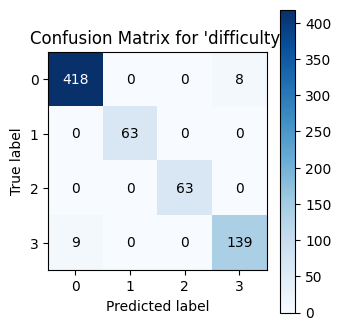

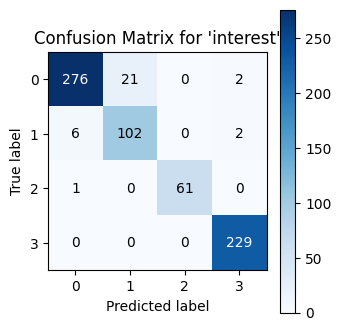

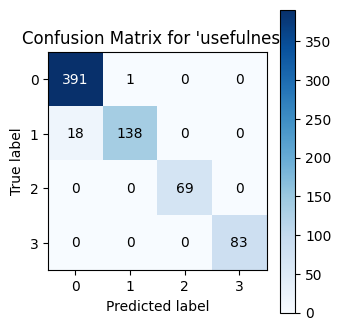

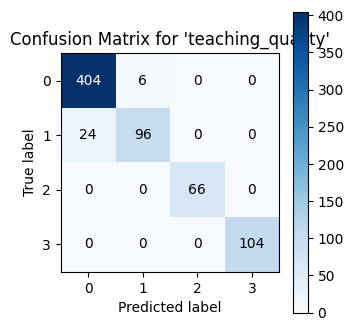

In [13]:
# ========================================
# Confusion Matrix
# ========================================


import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# --------------------------------------------
# 1. Define Dataset and Model (must match the original definitions)
# --------------------------------------------
tokenizer = None
def set_tokenizer(tok):
    global tokenizer
    tokenizer = tok

class CourseDataset(Dataset):
    def __init__(self, texts, labels, max_length=128):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class CourseSentimentModel(nn.Module):
    def __init__(self, model_name, num_labels_per_task):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden = self.bert.config.hidden_size
        self.classifiers = nn.ModuleList([
            nn.Linear(hidden, num_labels_per_task) for _ in range(4)
        ])

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return [clf(cls) for clf in self.classifiers]

# --------------------------------------------
# 2. Load CSV and reconstruct the same Test split (700 examples)
# --------------------------------------------
DATA_PATH = r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv"
df = pd.read_csv(DATA_PATH, encoding='cp1252', engine='python')
df.dropna(subset=[df.columns[0]], inplace=True)

labels_cols = ['difficulty', 'interest', 'usefulness', 'teaching_quality']
assert all(col in df.columns for col in labels_cols)

# Convert labels to numpy array
labels_all = df[labels_cols].astype(int).values  # shape = (N, 4)
texts = df[df.columns[0]].astype(str).tolist()
N = len(texts)

# Stratified selection for Test set
RND = 42
rng = np.random.RandomState(RND)

test_idx_set = set()
for i_label, col in enumerate(labels_cols):
    for v in [0, 1, 2, 3]:
        idxs_with_v = np.where(labels_all[:, i_label] == v)[0]
        if len(idxs_with_v) == 0:
            continue
        chosen = rng.choice(idxs_with_v)
        test_idx_set.add(int(chosen))

# Complete up to 20% of N
desired_test_size = int(round(0.20 * N))
remaining_to_add = desired_test_size - len(test_idx_set)
if remaining_to_add < 0:
    to_remove = rng.choice(
        list(test_idx_set),
        size=(len(test_idx_set) - desired_test_size),
        replace=False
    )
    for x in to_remove:
        test_idx_set.remove(x)
    remaining_to_add = 0
elif remaining_to_add > 0:
    all_idxs = set(range(N))
    available = np.array(list(all_idxs - test_idx_set))
    choices = rng.choice(available, size=remaining_to_add, replace=False)
    for x in choices:
        test_idx_set.add(int(x))

test_idx_list = sorted(test_idx_set)
X_test = [texts[i] for i in test_idx_list]
y_test = labels_all[test_idx_list]  # shape = (700, 4)

# --------------------------------------------
# 3. Load the saved best_model from disk
# --------------------------------------------
MODEL_PATH = Path(r"C:\Users\Gleb\Desktop\N.L.P\best_model.pth")
set_tokenizer(AutoTokenizer.from_pretrained("bert-base-multilingual-cased"))
loaded_model = CourseSentimentModel("bert-base-multilingual-cased", num_labels_per_task=4).to(torch.device("cuda"))
loaded_model.load_state_dict(torch.load(MODEL_PATH, map_location="cuda"))
loaded_model.eval()
best_model = loaded_model

# --------------------------------------------
# 4. Run predictions on Test set to get y_pred
# --------------------------------------------
# Assume BEST_BATCH_SIZE is known (e.g., 16)
BEST_BATCH_SIZE = 16

test_ds = CourseDataset(X_test, y_test.tolist())
test_loader = DataLoader(
    test_ds,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0
)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        ids = batch['input_ids'].to("cuda")
        mask = batch['attention_mask'].to("cuda")
        logits = best_model(ids, mask)
        preds_batch = torch.stack([torch.argmax(head_logits, dim=1) for head_logits in logits], dim=1)
        all_preds.append(preds_batch.cpu().numpy())
y_pred = np.vstack(all_preds)  # shape = (700, 4)

# --------------------------------------------
# 5. Plot a confusion matrix for each label
# --------------------------------------------
num_classes = [0, 1, 2, 3]

for i, lab in enumerate(labels_cols):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i], labels=num_classes)

    plt.figure(figsize=(3.5, 3.5))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(f"Confusion Matrix for '{lab}'")
    plt.colorbar()
    tick_marks = np.arange(len(num_classes))
    plt.xticks(tick_marks, num_classes)
    plt.yticks(tick_marks, num_classes)

    thresh = cm.max() / 2
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            plt.text(
                col, row, format(cm[row, col], 'd'),
                ha='center', va='center',
                color='white' if cm[row, col] > thresh else 'black'
            )

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

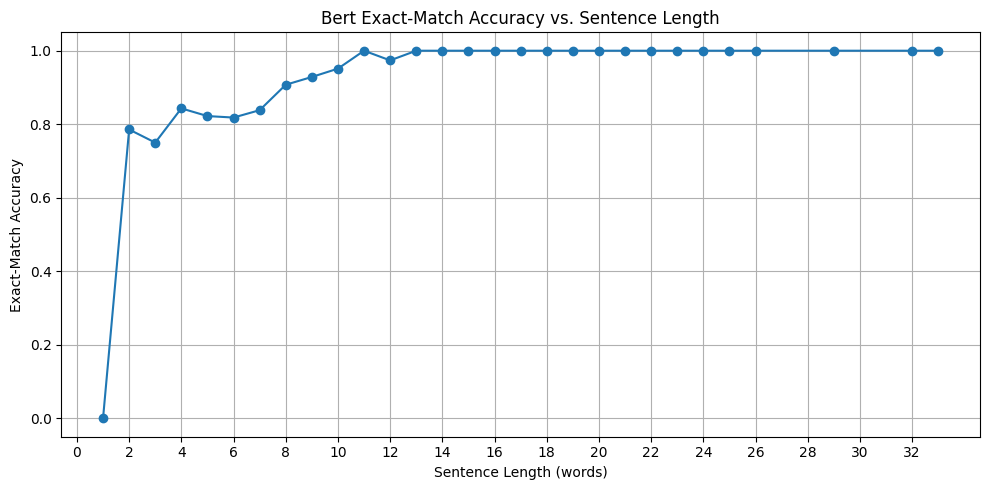

In [16]:
# =========================================
# Exact-Match Accuracy vs. Sentence Length
# =========================================

import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# Exact-Match Accuracy vs. Sentence Length
# --------------------------------------------

# Prerequisites (should already be in memory):
#   - X_test: List[str] of test sentences
#   - y_test: numpy array of shape (n_test, 4), true labels
#   - y_pred: numpy array of shape (n_test, 4), model predictions

# 1. Compute sentence lengths (in words)
lengths = np.array([len(text.split()) for text in X_test])  # array shape (n_test,)

# 2. Compute exact-match indicator per example (1 if all 4 labels match, else 0)
exact_matches = np.all(y_test == y_pred, axis=1).astype(int)  # array of 0/1

# 3. Aggregate by length: for each unique length, compute mean exact-match accuracy
unique_lengths = np.unique(lengths)
accuracy_by_length = [exact_matches[lengths == L].mean() for L in unique_lengths]

# 4. Plot
plt.figure(figsize=(10, 5))
plt.plot(unique_lengths, accuracy_by_length, marker='o', linestyle='-')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Exact-Match Accuracy")
plt.title("Bert Exact-Match Accuracy vs. Sentence Length")
plt.grid(True)

# 5. Set x-axis ticks in steps of 2
max_len = unique_lengths.max()
plt.xticks(np.arange(0, max_len + 1, 2))

plt.tight_layout()
plt.show()
